Set up QE

In [1]:
# setup env vars
%env ASE_ESPRESSO_COMMAND=/content/q-e/bin/pw.x -in PREFIX.pwi > PREFIX.pwo
%env ESPRESSO_PSEUDO=/content/q-e/pseudo

env: ASE_ESPRESSO_COMMAND=/content/q-e/bin/pw.x -in PREFIX.pwi > PREFIX.pwo
env: ESPRESSO_PSEUDO=/content/q-e/pseudo


## Calculations on a single-element (`Ta`) slab

> To a first approximation, you can create a BCC slab thick and wide enough so that it has enough "bulk" like material below the surface, enough sites to have a decent representation of the disordered alloy, and wide enough surface area so the deuterium atoms don't interact with their periodic image, but thin enough to limit the calculation to as few atoms as possible. You would want to use the relevant surface plane which most likely is (110) as in other BCC metals. 

In [34]:
!pwd

/usr/local/google/home/nqc/git/md


### Calculations on optimized slab
Extract the relaxed slab from our `pwscf` calculation and fix its position. Then insert a deuterium atom and run MD using QE.

In [3]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)


[[ 0.          0.         10.        ]
 [ 3.30579968  0.         10.        ]
 [ 6.61160035  0.         10.        ]
 [ 1.65290033  2.337554   10.        ]
 [ 4.95870001  2.337554   10.        ]
 [ 8.26449969  2.337554   10.        ]
 [ 3.30579968  4.675107   10.        ]
 [ 6.61160035  4.675107   10.        ]
 [ 9.91740002  4.675107   10.        ]
 [ 5.          4.         15.        ]]


<Axes: >

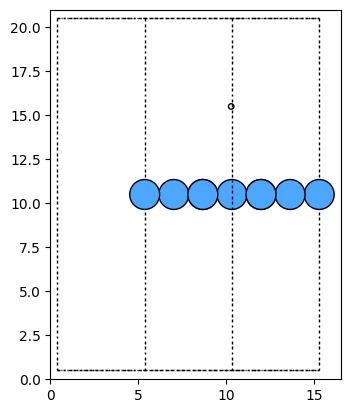

In [1]:
from ase import Atom, Atoms
from ase.constraints import FixAtoms
from ase.io.espresso import read_espresso_out, write_espresso_in
from ase.visualize import view
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import nglview

with open('Ta_3x3x1.out', 'r') as f:
  generator = read_espresso_out(f, index=slice(None))
  atoms = next(generator)

# Center slab in vacuum so there's space for a gas to interact
atoms.center(vacuum=10.0, axis=2)
mask = [atom for atom in atoms] #[atom.z < 3 for atom in atoms]
fixatoms = FixAtoms(mask=mask)
atoms.set_constraint(fixatoms)
atoms.set_pbc((True, True, False))

# Add unconstrained 2H
DEUTERIUM_MASS_AMU = 2.014
deuterium = Atom('H', mass=DEUTERIUM_MASS_AMU, position=(5., 4., 15.)) # 5 angstroms above the slab surface
atoms.append(deuterium)

# Visualize
#view(atoms, viewer='x3d')
print(atoms.positions)

fig, ax = plt.subplots()
plot_atoms(atoms, ax, radii=0.5, rotation=('90x,0y,180z'))

In [2]:
from ase.units import Rydberg

# 1 picosecond = n Rydberg a.u.
ps_to_au = 1e-12 / (4.8378 * 1e-17)
ps_to_au

20670.552730580017

In [3]:
import math

def velocity(atomic_mass, energy):
  """
  Computes the velocity of an atom in Hartree atomic units, given the atomic mass in atomic units and the energy in electronvolts.

  Args:
    atomic_mass: The atomic mass of the atom in atomic units.
    energy: The energy of the atom in electronvolts.

  Returns:
    The velocity of the atom in Hartree atomic units.
  """

  # Convert the atomic mass to kilograms.
  atomic_mass_kg = atomic_mass * 1.660539040e-27

  # Convert the energy to joules.
  energy_joules = energy * 1.60217662e-19

  # Calculate the velocity.
  velocity_ms = math.sqrt((2 * energy_joules) / atomic_mass_kg)

  # Convert the velocity to Hartree atomic units.
  velocity_ha = velocity_ms / 2.187691e6

  return velocity_ha

H_ATOMIC_MASS = 1.00784
assert math.isclose(velocity(H_ATOMIC_MASS, 40), 0.0400031, abs_tol=1e-6)

# Set atomic velocity

In [9]:
import os
%env INPUT_FILENAME=Ta_3x3x1_MD_velocity_gt0_initialT_300.in
%env OUTPUT_FILENAME=Ta_3x3x1_MD_velocity_gt0_initialT_300.out

env: INPUT_FILENAME=Ta_3x3x1_MD_velocity_gt0_initialT_300.in
env: OUTPUT_FILENAME=Ta_3x3x1_MD_velocity_gt0_initialT_300.out


In [11]:
INPUT_FILENAME = os.environ['INPUT_FILENAME']

atomic_velocities_str = """ATOMIC_VELOCITIES
Ta 0.0 0.0 0.0
Ta 0.0 0.0 0.0
Ta 0.0 0.0 0.0
Ta 0.0 0.0 0.0
Ta 0.0 0.0 0.0
Ta 0.0 0.0 0.0
Ta 0.0 0.0 0.0
Ta 0.0 0.0 0.0
Ta 0.0 0.0 0.0
H 0.0 0.0 {:.5f}
""".format(-velocity(H_ATOMIC_MASS, 30)) # eV

pseudopotentials = {
    'Ta': 'ta_pbe_v1.uspp.F.UPF',
    'H': 'h_pbe_v1.4.uspp.F.UPF'
}
input_data = {
    'control': {
        'calculation': 'md',
        'dt': 100, #1 * round(ps_to_au),
        'nstep': 3,
        'pseudo_dir': 'q-e/pseudo/',
        'outdir': 'outdir',
        'etot_conv_thr': 1e-5,
        'forc_conv_thr': 1e-4
    },
    'electrons': {
        #'conv_thr': 1e-5 #1e-6 # 1e-8
    },
    'ions': {
        'ion_velocities': 'from_input',
        'ion_temperature': 'initial',
        'tempw': 300 # 0?
    },
    'system': {
        'ecutwfc': 30,
        'occupations': 'smearing', # Need smearing params to avoid `Error in routine electrons (1): charge is wrong: smearing is needed`
        'smearing': 'gaussian',
        'degauss': 0.01
    }
}

k = 1
tstress, tprnfor = False, False # True, True
with open(INPUT_FILENAME, 'w') as f:
  write_espresso_in(f, atoms, input_data=input_data, pseudopotentials=pseudopotentials, tstress=tstress, tprnfor=tprnfor, kpts=(k, k, k))
  f.write(atomic_velocities_str)

!mpirun -np 12 q-e/bin/pw.x -inp $INPUT_FILENAME > $OUTPUT_FILENAME

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


Inside an image, PW and k-point parallelization can be performed: for instance,

   `mpirun -np 64 ph.x -ni 8 -nk 2 ...`
will run 8 images on 8 processors each, subdivided into 2 pools of 4 processors for k-point parallelization. In order to run the ph.x code with these flags the pw.x run has to be run with:
   `mpirun -np 8 pw.x -nk 2 ...`
without any `-nimage` flag. 

## Visualizing `nstep=5` trajectory

In [47]:
from ase.io.espresso import read_espresso_out
from ase.visualize import view
import matplotlib.pyplot as plt
import nglview

with open(os.environ['OUTPUT_FILENAME'], 'r') as f:
    generator = read_espresso_out(f, index=slice(None))
    atoms = next(generator)

fig, ax = plt.subplots()
plot_atoms(atoms, ax, radii=0.5, rotation=('90x,0y,180z'))

StopIteration: 

view(next(generator))